In [26]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import holidays
# 加载训练数据
#数据预处理
order_train = pd.read_csv('test/order_train2.csv')
#数据预处理
#可以得出数据没有缺失值

# 查看数据的基本信息
print(order_train.info())

# 查看数据的统计量
print(order_train.describe())

#查看是否有重复值
print('查看是否有重复值')
duplicated=order_train.duplicated()
print(order_train.duplicated().sum())
print(order_train[duplicated])


#删除重复值
order_train = order_train.drop_duplicates()
print(order_train.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677214 entries, 0 to 677213
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         677214 non-null  object 
 1   sales_region_code  677214 non-null  int64  
 2   item_code          677214 non-null  int64  
 3   first_cate_code    677214 non-null  int64  
 4   second_cate_code   677214 non-null  int64  
 5   sales_chan_name    677214 non-null  object 
 6   item_price         677214 non-null  float64
 7   ord_qty            677214 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 41.3+ MB
None
       sales_region_code      item_code  first_cate_code  second_cate_code  \
count      677214.000000  677214.000000    677214.000000     677214.000000   
mean          102.881955   21002.069281       304.939716        406.446876   
std             1.490684     591.540499         2.006534          3.084888   
min           101.00

In [27]:
# 将订单数据中的日期从字符串类型转换为日期类型
order_train['order_date'] = pd.to_datetime(order_train['order_date'])
order_train = order_train[(order_train['order_date'].dt.year >= 2018)]
order_train['is_holiday'] = order_train['order_date'].isin(holidays.China(years=[2015,2016,2017,2018]))
order_train['is_holiday'] = order_train['is_holiday'].astype(int)
order_train['year'] = order_train['order_date'].dt.year
order_train['month'] = order_train['order_date'].dt.month
order_train['day'] = order_train['order_date'].dt.day
order_train['weekday'] = order_train['order_date'].dt.weekday
order_train['week'] = order_train['order_date'].dt.isocalendar().week.astype('int64')
order_train["season"] = ((order_train["order_date"].dt.month-1)//3+1)

order_train = order_train[order_train['ord_qty'] < order_train['ord_qty'].quantile(0.99)]  # 清除需求量极大异常值
order_train['sales_chan_name'] = order_train['sales_chan_name'].replace({'online': 0, 'offline': 1})

predict_df = pd.read_csv('test/predict_sku2.csv')
print(order_train)

       order_date  sales_region_code  item_code  first_cate_code  \
375290 2018-01-01                105      20169              308   
375291 2018-01-01                105      22015              304   
375292 2018-01-01                105      20935              304   
375293 2018-01-01                105      21296              304   
375294 2018-01-01                105      20814              301   
...           ...                ...        ...              ...   
677209 2019-03-20                102      20016              303   
677210 2019-03-20                102      20449              306   
677211 2019-03-20                102      20240              306   
677212 2019-03-20                102      20775              306   
677213 2019-03-20                102      20777              308   

        second_cate_code  sales_chan_name  item_price  ord_qty  is_holiday  \
375290               404                0      1215.0       16           1   
375291               409   

In [28]:
import numpy as np
code_columns=['sales_region_code', 'first_cate_code', 'second_cate_code']
for cc in code_columns:
    order_train[cc] = order_train[cc].astype('category')
order_train = pd.get_dummies(order_train, columns=code_columns, drop_first=True)

# order_train['month_sin'] = np.sin((order_train['month'] - 1) * (2.0 * np.pi / 12))
# order_train['month_cos'] = np.cos((order_train['month'] - 1) * (2.0 * np.pi / 12))
# order_train['season_sin'] = np.sin((order_train['season'] - 1) * (2.0 * np.pi / 4))
# order_train['season_cos'] = np.cos((order_train['season'] - 1) * (2.0 * np.pi / 4))
selected_features = order_train.columns.drop(['order_date', 'ord_qty','item_price','sales_chan_name'])
print(selected_features)

Index(['item_code', 'is_holiday', 'year', 'month', 'day', 'weekday', 'week',
       'season', 'sales_region_code_102', 'sales_region_code_103',
       'sales_region_code_105', 'first_cate_code_302', 'first_cate_code_303',
       'first_cate_code_304', 'first_cate_code_305', 'first_cate_code_306',
       'first_cate_code_307', 'first_cate_code_308', 'second_cate_code_402',
       'second_cate_code_403', 'second_cate_code_404', 'second_cate_code_405',
       'second_cate_code_406', 'second_cate_code_407', 'second_cate_code_408',
       'second_cate_code_409', 'second_cate_code_410', 'second_cate_code_411',
       'second_cate_code_412'],
      dtype='object')


In [29]:
# 训练集和验证集的划分
X_train, X_val, y_train, y_val = train_test_split(order_train[selected_features], order_train['ord_qty'], test_size=0.2, random_state=42)
print(len(X_train))

238940


In [ ]:
from sklearn.model_selection import GridSearchCV
# 网格搜索
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.01, 0.1, 1]
}
xgb = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 交叉验证的结果
print("最优参数：", grid_search.best_params_)
print("最优得分：", np.sqrt(-grid_search.best_score_))#n_estimators=1000, learning_rate=0.05, max_depth=9, subsample=0.8, colsample_bytree=0.8, gamma=0.1

In [39]:
# XGBoost模型
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=9, subsample=0.8, colsample_bytree=0.8, gamma=0.1)
# eval_set = [(X_train, y_train), (X_val, y_val)]
# eval_metric = ["rmse"]
# results = {}
# 模型训练
xgb.fit(X_train, y_train, eval_metric='rmse', early_stopping_rounds=10, eval_set=[(X_val, y_val)])



[0]	validation_0-rmse:124.51730
[1]	validation_0-rmse:122.68228
[2]	validation_0-rmse:121.05920
[3]	validation_0-rmse:119.60188
[4]	validation_0-rmse:118.23534
[5]	validation_0-rmse:116.97583
[6]	validation_0-rmse:115.87752
[7]	validation_0-rmse:114.86635
[8]	validation_0-rmse:113.90795
[9]	validation_0-rmse:113.04083
[10]	validation_0-rmse:112.22900
[11]	validation_0-rmse:111.48346
[12]	validation_0-rmse:110.77768
[13]	validation_0-rmse:110.21059
[14]	validation_0-rmse:109.63189
[15]	validation_0-rmse:109.10902
[16]	validation_0-rmse:108.62329
[17]	validation_0-rmse:108.12359
[18]	validation_0-rmse:107.71173
[19]	validation_0-rmse:107.37697
[20]	validation_0-rmse:106.86312
[21]	validation_0-rmse:106.55037
[22]	validation_0-rmse:106.07282
[23]	validation_0-rmse:105.79475
[24]	validation_0-rmse:105.41587
[25]	validation_0-rmse:105.15918
[26]	validation_0-rmse:104.94104
[27]	validation_0-rmse:104.75309
[28]	validation_0-rmse:104.49248
[29]	validation_0-rmse:104.23846
[30]	validation_0-rm

[250]	validation_0-rmse:96.83606
[251]	validation_0-rmse:96.83366
[252]	validation_0-rmse:96.83483
[253]	validation_0-rmse:96.82418
[254]	validation_0-rmse:96.80982
[255]	validation_0-rmse:96.79959
[256]	validation_0-rmse:96.79065
[257]	validation_0-rmse:96.78674
[258]	validation_0-rmse:96.77641
[259]	validation_0-rmse:96.76487
[260]	validation_0-rmse:96.75058
[261]	validation_0-rmse:96.75135
[262]	validation_0-rmse:96.75229
[263]	validation_0-rmse:96.74721
[264]	validation_0-rmse:96.73756
[265]	validation_0-rmse:96.72861
[266]	validation_0-rmse:96.72667
[267]	validation_0-rmse:96.71656
[268]	validation_0-rmse:96.71400
[269]	validation_0-rmse:96.71669
[270]	validation_0-rmse:96.71028
[271]	validation_0-rmse:96.70246
[272]	validation_0-rmse:96.70149
[273]	validation_0-rmse:96.69472
[274]	validation_0-rmse:96.68488
[275]	validation_0-rmse:96.67754
[276]	validation_0-rmse:96.66639
[277]	validation_0-rmse:96.65996
[278]	validation_0-rmse:96.65784
[279]	validation_0-rmse:96.65118
[280]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

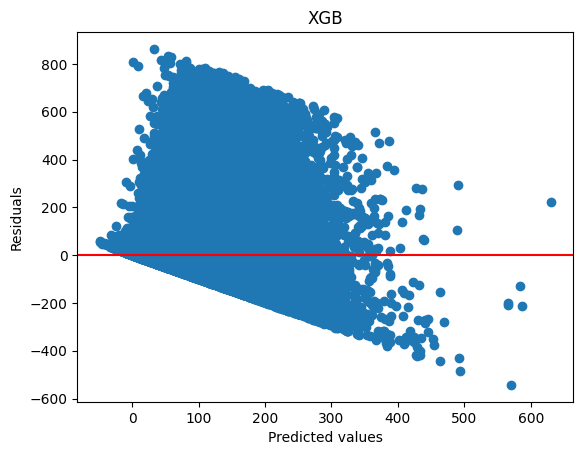

In [9]:
import matplotlib.pyplot as plt
import numpy as np
y_pred = xgb.predict(X_val)

# 计算残差
residuals = y_val - y_pred

# 绘制残差图
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('XGB')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


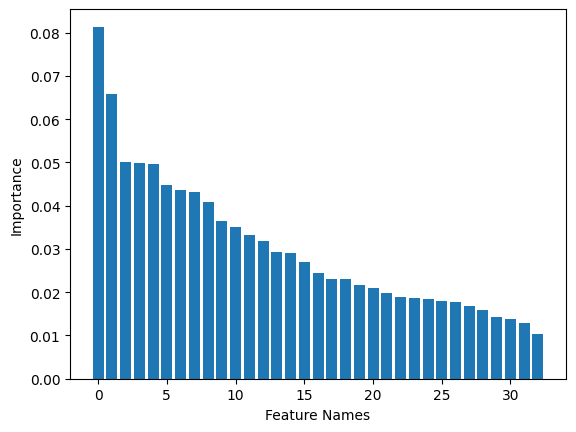

In [113]:
import numpy as np

# 获取特征重要性
importance = xgb.feature_importances_

# 获取特征名称
feat_names = xgb.get_booster().feature_names

# 将特征名称和特征重要性排序
sorted_idx = importance.argsort()[::-1]

# 将特征重要性和特征名称进行可视化
plt.bar(np.arange(len(feat_names)), importance[sorted_idx])

plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.show()

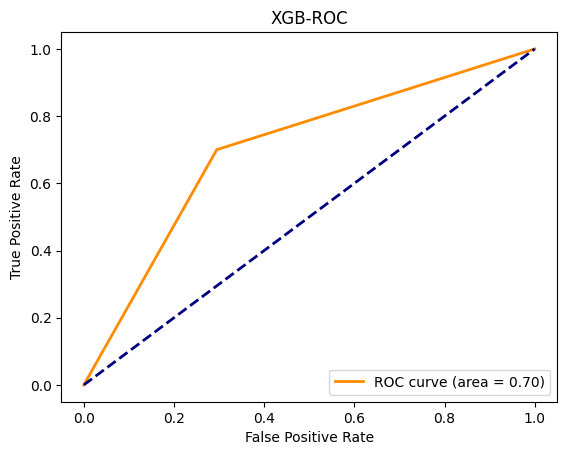

In [33]:
from sklearn.metrics import roc_curve, auc
# 预测概率
y_score = xgb.predict(X_val)

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(np.where(y_val >= np.median(y_val), 1, 0), np.where(y_pred >= np.median(y_pred), 1, 0))
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB-ROC')
plt.legend(loc="lower right")
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score
# 预测
y_pred = xgb.predict(X_val)
print(len(y_pred))
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# 计算均方误差（MSE）、均方根误差（RMSE）、平均绝对误差（MAE）
# print(model.score(X_train, y_train))
# print(model.score(X_test, y_test))
print('MSE:', mse)
print('RMSE:',rmse )
print('MAE:', mae)
print('R2:',r2 )

# MSE: 9210.642411957644
# RMSE: 95.97209183902184
# MAE: 55.75860207664546
# R2: 0.23272618714328241

59735
MSE: 9256.490292356504
RMSE: 96.21065581502137
MAE: 55.960690679157445
R2: 0.22890692281494818


In [ ]:
# 绘制差异图
x_values = np.arange(len(y_true))
plt.plot(x_values, y_true, '-o', label='True')
plt.plot(x_values, y_pred, '-o', label='Predicted')
plt.plot(x_values, y_true1, '-x', label='True1')
plt.plot(x_values, y_pred1, '-x', label='Predicted1')
plt.legend()
plt.title('Prediction vs. True Values')
plt.xlabel('Data points')
plt.ylabel('Value')
plt.show()

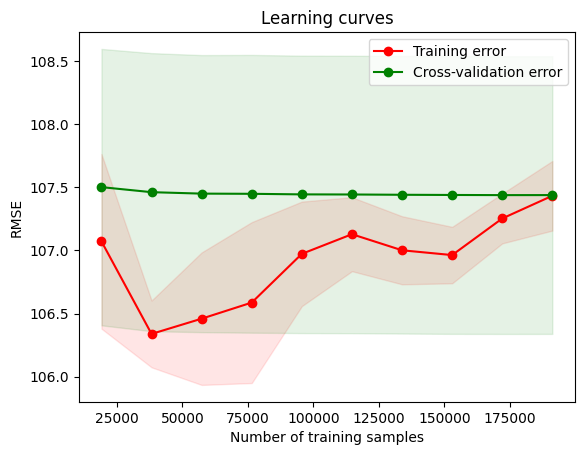

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# 创建一个简单的线性回归模型
model = LinearRegression()

# 计算不同观测点下的训练集和验证集误差
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_root_mean_squared_error'
)

# 计算训练集和验证集的平均误差，以及标准差
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 绘制学习曲线
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Number of training samples')
plt.ylabel('RMSE')
plt.title('Learning curves')
plt.legend(loc='best')
plt.show()

In [45]:
import time
predict_df = pd.read_csv('test/predict_sku2.csv')
date_range = pd.date_range(start='2019-04-01', end='2019-06-30', freq='D')
cols = ['sales_region_code', 'item_code', '2019年4月预测需求量', '2019年5月预测需求量', '2019年6月预测需求量']
predicted_demand_df = pd.DataFrame(columns=cols)
sales_region_code =     predict_df['sales_region_code']
item_code = predict_df['item_code']
    
for cc in code_columns:
    predict_df[cc] = predict_df[cc].astype('category')

predict_df = pd.get_dummies(predict_df, columns=code_columns,drop_first=True)
print("开始预测")
start_time = time.time()
for _, row in predict_df.iterrows():
    predict_data = row.to_frame().transpose()

#     region = int(predict_data['sales_region_code'])
    code = int(predict_data['item_code'])
    
    # 扩展日期列
    predict_data = pd.concat([predict_data]*len(date_range), ignore_index=True)
    predict_data['date'] = date_range
   
    # 提取特征
    predict_data['is_holiday'] = predict_data['date'].isin(holidays.China(years=2019))
    predict_data['year'] = predict_data['date'].dt.year
    predict_data['month'] = predict_data['date'].dt.month
    predict_data['weekday'] = predict_data['date'].dt.weekday
    predict_data['day'] = predict_data['date'].dt.day
    predict_data['week'] = predict_data['date'].dt.isocalendar().week.astype(int)
    predict_data["season"] = ((predict_data["date"].dt.month-1)//3+1)
    code_columns=['sales_region_code', 'first_cate_code', 'second_cate_code']
    predict_data.columns.drop('date')
#     predict_data['month_sin'] = np.sin((predict_data['month'] - 1) * (2.0 * np.pi / 12))
#     predict_data['month_cos'] = np.cos((predict_data['month'] - 1) * (2.0 * np.pi / 12))
#     predict_data['season_sin'] = np.sin((predict_data['season'] - 1) * (2.0 * np.pi / 4))
#     predict_data['season_cos'] = np.cos((predict_data['season'] - 1) * (2.0 * np.pi / 4))
    # 进行预测
    X_predict = predict_data[selected_features]
    y_predict = xgb.predict(X_predict)

    # 计算月总需求量
    predict_data['demand'] = y_predict
    monthly_demand = predict_data.groupby(['year', 'month'], as_index=False)['demand'].sum().astype(int)
    
    row = [1,code, 0, 0, 0]
    for _, row_month in monthly_demand.iterrows():
        month_col = '2019年{}月预测需求量'.format(int(row_month['month']))
        row[cols.index(month_col)] = row_month['demand']     
    predicted_demand_df.loc[len(predicted_demand_df)] = row
    print(predicted_demand_df)
    
end_time = time.time()


开始预测
   sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                  1      20002           405           433           609
   sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                  1      20002           405           433           609
1                  1      20003          2023          3321          2899
   sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                  1      20002           405           433           609
1                  1      20003          2023          3321          2899
2                  1      20004           801           993           913
   sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                  1      20002           405           433           609
1                  1      20003          2023          3321          2899
2                  1      20004           801           993           913
3                  1      20006  

    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                   1      20002           405           433           609
1                   1      20003          2023          3321          2899
2                   1      20004           801           993           913
3                   1      20006           762          1033           990
4                   1      20008           804           906           711
5                   1      20010          1546          1017          1111
6                   1      20011          1367          1281          1350
7                   1      20014          2052          1844          2090
8                   1      20016          1573          1438          1228
9                   1      20017          1432          1338          1112
10                  1      20018          1504           979           725
11                  1      20020          1316          1305          1011
12                  1    

    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                   1      20002           405           433           609
1                   1      20003          2023          3321          2899
2                   1      20004           801           993           913
3                   1      20006           762          1033           990
4                   1      20008           804           906           711
5                   1      20010          1546          1017          1111
6                   1      20011          1367          1281          1350
7                   1      20014          2052          1844          2090
8                   1      20016          1573          1438          1228
9                   1      20017          1432          1338          1112
10                  1      20018          1504           979           725
11                  1      20020          1316          1305          1011
12                  1    

    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                   1      20002           405           433           609
1                   1      20003          2023          3321          2899
2                   1      20004           801           993           913
3                   1      20006           762          1033           990
4                   1      20008           804           906           711
5                   1      20010          1546          1017          1111
6                   1      20011          1367          1281          1350
7                   1      20014          2052          1844          2090
8                   1      20016          1573          1438          1228
9                   1      20017          1432          1338          1112
10                  1      20018          1504           979           725
11                  1      20020          1316          1305          1011
12                  1    

    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                   1      20002           405           433           609
1                   1      20003          2023          3321          2899
2                   1      20004           801           993           913
3                   1      20006           762          1033           990
4                   1      20008           804           906           711
5                   1      20010          1546          1017          1111
6                   1      20011          1367          1281          1350
7                   1      20014          2052          1844          2090
8                   1      20016          1573          1438          1228
9                   1      20017          1432          1338          1112
10                  1      20018          1504           979           725
11                  1      20020          1316          1305          1011
12                  1    

    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                   1      20002           405           433           609
1                   1      20003          2023          3321          2899
2                   1      20004           801           993           913
3                   1      20006           762          1033           990
4                   1      20008           804           906           711
5                   1      20010          1546          1017          1111
6                   1      20011          1367          1281          1350
7                   1      20014          2052          1844          2090
8                   1      20016          1573          1438          1228
9                   1      20017          1432          1338          1112
10                  1      20018          1504           979           725
11                  1      20020          1316          1305          1011
12                  1    

    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                   1      20002           405           433           609
1                   1      20003          2023          3321          2899
2                   1      20004           801           993           913
3                   1      20006           762          1033           990
4                   1      20008           804           906           711
..                ...        ...           ...           ...           ...
59                  1      20156          2365          2281          2113
60                  1      20157          2780          2796          1946
61                  1      20160          1794          1804          1483
62                  1      20161          1130           995           821
63                  1      20162          1010           863           746

[64 rows x 5 columns]
    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0 

    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                   1      20002           405           433           609
1                   1      20003          2023          3321          2899
2                   1      20004           801           993           913
3                   1      20006           762          1033           990
4                   1      20008           804           906           711
..                ...        ...           ...           ...           ...
68                  1      20178           677           799           741
69                  1      20182          1307          1306          1085
70                  1      20185           894           573           365
71                  1      20189          1699          1551          1330
72                  1      20190          1510          1621          1293

[73 rows x 5 columns]
    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0 

    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                   1      20002           405           433           609
1                   1      20003          2023          3321          2899
2                   1      20004           801           993           913
3                   1      20006           762          1033           990
4                   1      20008           804           906           711
..                ...        ...           ...           ...           ...
77                  1      20198          1556          1513          1322
78                  1      20199           840           760           642
79                  1      20204          1468          1422          1333
80                  1      20206          2178          2001          1849
81                  1      20213          2123          1989          1836

[82 rows x 5 columns]
    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0 

    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                   1      20002           405           433           609
1                   1      20003          2023          3321          2899
2                   1      20004           801           993           913
3                   1      20006           762          1033           990
4                   1      20008           804           906           711
..                ...        ...           ...           ...           ...
87                  1      20224          2481          2379          3029
88                  1      20226          1902          1745          1598
89                  1      20227          1210          1237          1713
90                  1      20230          1022           729           611
91                  1      20234          1050           758           616

[92 rows x 5 columns]
    sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0 

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
96                   1      20245           201           119           160
97                   1      20248          1472          1404           929
98                   1      20252          2172          1937          1651
99                   1      20253          3712          3652          1819
100                  1      20254          2209          2190          1744

[101 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
105                  1      20268          2346          2185          1636
106                  1      20272          3485          3182          3229
107                  1      20273          2433          2382          2193
108                  1      20275          3232          2923          2983
109                  1      20278          4202          4234          3964

[110 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
114                  1      20291          2024          1938          1459
115                  1      20292          3311          3382          3217
116                  1      20296          3958          4045          3860
117                  1      20297          1092           983           595
118                  1      20300          1677          1722          1670

[119 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
123                  1      20321          1077          1092           956
124                  1      20323          3443          4018          3934
125                  1      20324          1953          2126          2067
126                  1      20327           904           733           715
127                  1      20329          1198          1133          1461

[128 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
132                  1      20341          2319          2386          2503
133                  1      20342          3761          3580          3311
134                  1      20343          1632          1274          1114
135                  1      20344          2434          2565          2678
136                  1      20346          3055          2781          2343

[137 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
141                  1      20357          1034          1036          1099
142                  1      20359          3186          3311          3171
143                  1      20366           763           698           623
144                  1      20368          4001          3417          2922
145                  1      20370          2842          2623          2433

[146 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
150                  1      20389          1304          1209          1064
151                  1      20394           381           280           262
152                  1      20396          1871          1704          1583
153                  1      20397          1343          1364          1303
154                  1      20398          2378          2305          2201

[155 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
159                  1      20412          1053           763           494
160                  1      20413          2095          1659          1198
161                  1      20414          1947          2111          2126
162                  1      20415          1638          1613          1501
163                  1      20418          1418          1270          1145

[164 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
168                  1      20428          6196          6231          5872
169                  1      20433           773           784           766
170                  1      20434           718           495           291
171                  1      20436           839           486           336
172                  1      20438           847           486           343

[173 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
178                  1      20452           980          1026          1004
179                  1      20453          2071          2295          1817
180                  1      20457          3571          3842          3683
181                  1      20459          1570          1551          1519
182                  1      20461           467           397           440

[183 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
187                  1      20483          1673          1663          1622
188                  1      20485          1172          1231          1256
189                  1      20492          1135          1264          1458
190                  1      20494          1134           883           607
191                  1      20499          1049           998           767

[192 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
196                  1      20510          2025          2198          2139
197                  1      20512          2025          2196          2144
198                  1      20513          2007          2153          2126
199                  1      20515          1831          1766          1716
200                  1      20522          1560          1484          1434

[201 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
205                  1      20538          1419          1114           776
206                  1      20540           685           642           614
207                  1      20545          4545          4569          4378
208                  1      20549          2381          2606          2538
209                  1      20551          2037          1695          1350

[210 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
214                  1      20561           938           925           904
215                  1      20563           796           783           767
216                  1      20565          1556          1656          1591
217                  1      20567           238           218           252
218                  1      20569           914           894           874

[219 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
223                  1      20583          6599          6728          6214
224                  1      20584          1703          1420          1234
225                  1      20587          1623          1306           977
226                  1      20596          1504          1444          1114
227                  1      20597          4805          5008          4584

[228 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
232                  1      20614          1877          1670          1198
233                  1      20618          2619          2971          2614
234                  1      20625          1987          1979          1615
235                  1      20627          2215          2393          2584
236                  1      20628          1914          1943          1701

[237 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
241                  1      20648          4381          4117          4027
242                  1      20652          1158          1017          1218
243                  1      20653          2048          2209          2434
244                  1      20654           531           641          1128
245                  1      20655          1139           934           932

[246 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
250                  1      20662          2282          2327          2306
251                  1      20664          1548          1670          2062
252                  1      20666          1596          1777          2155
253                  1      20668          1051           896           718
254                  1      20673          1397          1283          1021

[255 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
259                  1      20687          2018          2362          2745
260                  1      20688          1200          1233          1139
261                  1      20689          1427          1480          1329
262                  1      20692          2570          3077          2712
263                  1      20693          2369          2883          2400

[264 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
268                  1      20700          1342          1198          1122
269                  1      20701          2392          2301          2089
270                  1      20703          1627          1551          1328
271                  1      20704          1647          1770          2169
272                  1      20707          1411          1151           913

[273 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
277                  1      20722          1364          1151           842
278                  1      20727          2091          2049          1837
279                  1      20729          1299          1034           828
280                  1      20731          1396          1294          1114
281                  1      20734          1843          1578          1296

[282 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
286                  1      20743          2733          2932          2352
287                  1      20744          1775          1791          1409
288                  1      20748          1557          1828          1440
289                  1      20749          2761          3026          3102
290                  1      20750          2632          2429          1940

[291 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
296                  1      20768          1493          1818          1746
297                  1      20769          1167          1451          1597
298                  1      20775           993           729           538
299                  1      20777          1503          1777          1749
300                  1      20784          1087          1026           992

[301 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
305                  1      20795          2186          2330          2652
306                  1      20797          1263          1290          1341
307                  1      20803          1332           920           720
308                  1      20805          1434           974           773
309                  1      20808           983           660           461

[310 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
314                  1      20823          1334          1290          1295
315                  1      20826          1540          1528          1530
316                  1      20827          1468          1538          1443
317                  1      20828          4968          6156          5953
318                  1      20831          4183          4661          3934

[319 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
324                  1      20842          3162          3380          3448
325                  1      20849          2243          2304          2195
326                  1      20853          1052          1136          1120
327                  1      20854          1270          1260          1260
328                  1      20858          3982          4094          4146

[329 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
333                  1      20879          1765          1814          1677
334                  1      20880          1552          1583          1463
335                  1      20886           476           427           407
336                  1      20892           944           753           527
337                  1      20894          1169          1261          1076

[338 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
342                  1      20904          3228          3224          2945
343                  1      20911           526           523           598
344                  1      20913          2292          2113          1812
345                  1      20914          2180          2190          2261
346                  1      20916          3297          3134          2814

[347 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
351                  1      20932          3387          3469          3512
352                  1      20939          1886          2550          2400
353                  1      20940           492           484           456
354                  1      20941          1485          1710          1287
355                  1      20942          2556          2807          2296

[356 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
360                  1      20955          1424          1128           963
361                  1      20956           711           774          1122
362                  1      20957          2089          2130          2022
363                  1      20959          1092          1090          1136
364                  1      20965          1459          1289           961

[365 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
369                  1      20976           859           724           594
370                  1      20977           832           789           662
371                  1      20978          1414          1399          1353
372                  1      20980          1523          1561          1511
373                  1      20981          1173           819           568

[374 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
378                  1      20994          3305          3234          2799
379                  1      20996          3077          2923          2513
380                  1      20999          2737          2787          2580
381                  1      21000           548           482           537
382                  1      21001          1172          1147          1056

[383 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
387                  1      21022           484           386           492
388                  1      21023           313           269           405
389                  1      21026          1927          1848          1743
390                  1      21027          2101          1813          1643
391                  1      21028           915           773           716

[392 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
396                  1      21043          1493          1353          1225
397                  1      21046          1157          1133           861
398                  1      21047          1136          1089          1046
399                  1      21049          1312           956           754
400                  1      21052          1243          1159          1160

[401 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
405                  1      21062          1428          1500          1362
406                  1      21064          1340          1535          1398
407                  1      21067          1391          1387          1241
408                  1      21068          1849          1843          1705
409                  1      21080          1744          1611          1438

[410 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
414                  1      21090           890           879           743
415                  1      21091          1107          1322          1197
416                  1      21094           949           927           784
417                  1      21096          4755          4585          4498
418                  1      21098          1312          1506          1364

[419 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
423                  1      21110          1101          1168          1449
424                  1      21111           541           477           444
425                  1      21114          1303          1497          1348
426                  1      21115          1103          1176          1451
427                  1      21117          2424          2301          2108

[428 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
432                  1      21125          1237           917           689
433                  1      21129           943           953           784
434                  1      21131          1023           718           632
435                  1      21138           561           209           252
436                  1      21149          1401          1256           816

[437 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
441                  1      21157          1059          1225          1211
442                  1      21160          1064           958           936
443                  1      21166           758           769           777
444                  1      21167          1064           934           829
445                  1      21168            94           249           365

[446 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
450                  1      21185           511           559           931
451                  1      21188           301           234           223
452                  1      21192            67            18            65
453                  1      21195           637           602           471
454                  1      21197           631           600           471

[455 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
467                  1      21245           654           642           568
468                  1      21249          3895          4120          5591
469                  1      21250          1453          1429          1436
470                  1      21253          2466          2357          2212
471                  1      21255          2279          2171          2006

[472 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
476                  1      21272           642           674           610
477                  1      21274          2386          2482          2454
478                  1      21278          1733          1761          1745
479                  1      21280           866           695           643
480                  1      21285          1644          1499          1334

[481 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
485                  1      21298          1827          1619          1430
486                  1      21303          1612          1638          1478
487                  1      21305          1973          1694          1499
488                  1      21306          1820          1607          1422
489                  1      21312          1561          1582          1481

[490 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
495                  1      21330           955           924           924
496                  1      21331           838           582           452
497                  1      21335          1394          1400          1311
498                  1      21338          1304          1026           828
499                  1      21340          1304          1026           828

[500 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
505                  1      21356           784           548           472
506                  1      21358          1708          1508          1249
507                  1      21359          2152          2052          1747
508                  1      21361          2586          2632          2523
509                  1      21363          1370          1358          1384

[510 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
515                  1      21382           368           313           347
516                  1      21386           407           371           365
517                  1      21390           474           431           363
518                  1      21391           716           679           715
519                  1      21394          3268          2842          2655

[520 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
524                  1      21408          2906          2518          2269
525                  1      21409           624           444           588
526                  1      21414          3139          2788          2436
527                  1      21415          1772          1741          1712
528                  1      21416          1955          2241          2218

[529 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
533                  1      21430          1051           824           729
534                  1      21431          2118          1832          1905
535                  1      21432          2219          2573          2455
536                  1      21433          1651          1394          1293
537                  1      21437           873           931          1004

[538 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
542                  1      21451           970          1431          1197
543                  1      21456          2100          1986          1807
544                  1      21460           189           177           271
545                  1      21461          1517          1580          1521
546                  1      21462           350           551           594

[547 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
551                  1      21480          1417          1490          1355
552                  1      21481          1231          1418          1693
553                  1      21484          1940          2006          1881
554                  1      21488           891          1009          1401
555                  1      21490           885           655           464

[556 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
560                  1      21497          1711          1423          1235
561                  1      21501          1574          1361          1176
562                  1      21507          1560          1343          1002
563                  1      21509          2742          2893          2661
564                  1      21518          2379          2529          2305

[565 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
569                  1      21532          1413          1272          1171
570                  1      21545          1609          1355          1064
571                  1      21546          1738          1492          1124
572                  1      21548          1627          1381          1008
573                  1      21549          2250          2378          3013

[574 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
578                  1      21561          1942          1698          1330
579                  1      21569          1062          1285          1435
580                  1      21573          2879          2651          2383
581                  1      21579          2470          2169          1821
582                  1      21581          1042          1068          1110

[583 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
587                  1      21596          1041          1085           961
588                  1      21597           903           936           782
589                  1      21601          3406          3251          2922
590                  1      21602          1646          1444          1031
591                  1      21605           657           613           598

[592 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
596                  1      21617           910           845           844
597                  1      21619          1844          2261          1247
598                  1      21624          1931          1689          1207
599                  1      21629          2028          1832          1346
600                  1      21630          1432          1573          1575

[601 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
605                  1      21644          1636          1607          1668
606                  1      21648           916           622           400
607                  1      21650          1620          1344          1262
608                  1      21652           698           614           488
609                  1      21653          1504          1225           945

[610 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
614                  1      21681           907           837           716
615                  1      21684          1077           924           771
616                  1      21687          1428          1187           949
617                  1      21690          1183          1154          1098
618                  1      21694          1086          1045          1143

[619 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
631                  1      21734          1605          1735          2164
632                  1      21737          1657          1795          2219
633                  1      21740          1452          1581          2011
634                  1      21743          1457          1585          2015
635                  1      21745          1403          1402          1331

[636 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
640                  1      21755           906          1005          1473
641                  1      21757           304           261           330
642                  1      21759           898           832           777
643                  1      21760           846           779           693
644                  1      21763          1113          1377          1393

[645 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
649                  1      21772           679           766          1257
650                  1      21775           948           888           794
651                  1      21777           794           757           700
652                  1      21779          1484          1589          2043
653                  1      21780           850           747           557

[654 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
658                  1      21796          1791          1710          1754
659                  1      21809          1884          1771          2365
660                  1      21810          1085           697           330
661                  1      21812          1286          1125          1155
662                  1      21814          1258           870           455

[663 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
667                  1      21823          1162          1045           908
668                  1      21830          1537          1568          1505
669                  1      21835          1306          1702          1296
670                  1      21839           852           794          1324
671                  1      21840           749           579           384

[672 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
677                  1      21865           642           422           211
678                  1      21867          1179          1220           907
679                  1      21871           707           491           255
680                  1      21876          2207          2278          2215
681                  1      21878          2014          2036          1987

[682 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
686                  1      21888          2067          1845          1559
687                  1      21895           889          1337          1493
688                  1      21899          1951          1479          1347
689                  1      21900          2082          1938          2468
690                  1      21901          3098          2436          2098

[691 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
695                  1      21914          1480          1300           752
696                  1      21915           478           399           458
697                  1      21916          1454          1471          1129
698                  1      21917          1577          1516          1158
699                  1      21920          1567          1489          1151

[700 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
704                  1      21940           994           892           871
705                  1      21942          3713          3466          2352
706                  1      21943          3052          2883          2157
707                  1      21945          2170          1978          1831
708                  1      21947          1423          1524          2058

[709 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
714                  1      21966          1377          1479          2009
715                  1      21967           863           851           849
716                  1      21969          1845          1692          1553
717                  1      21974          2354          1316           951
718                  1      21977          1079           877          1489

[719 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
724                  1      21994          2165          2404          2127
725                  1      21995          1921          1669          1343
726                  1      22002          2386          2433          1947
727                  1      22005          2048          2293          1820
728                  1      22007          2079          2121          2105

[729 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
733                  1      22025           632           418           340
734                  1      22027           514           491             5
735                  1      22028          2138          2049          1697
736                  1      22030          1217          1326          1978
737                  1      22035           982           926           678

[738 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
743                  1      22048          4028          3365          1382
744                  1      22049          1238          1167           873
745                  1      22051           870          1060           266
746                  1      22053          1499          1470           832
747                  1      22056          3193          3536          3318

[748 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
752                  1      22066          8414          8647          7727
753                  1      22071          2401          2268          1689
754                  1      22075          1829          2535          4064
755                  1      22081           858           734           640
756                  1      22082          2155          1942          1572

[757 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
762                  1      20008           587           825           658
763                  1      20010          2861          2830          2530
764                  1      20011          1507          1785          1627
765                  1      20014          3901          4312          3587
766                  1      20016          1390          1398          1253

[767 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
771                  1      20025          2154          2474          2473
772                  1      20033           747          1103           753
773                  1      20038           782          1135           741
774                  1      20041          2086          2203          2011
775                  1      20045          1683          1515          1244

[776 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
781                  1      20071          1311          1266           996
782                  1      20075          1661          1825          1720
783                  1      20076           793           929           661
784                  1      20082          1117          1317          1205
785                  1      20085          1654          1962          1491

[786 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
791                  1      20107          2702          3080          3415
792                  1      20108          2953          3209          4067
793                  1      20111          2620          2954          2873
794                  1      20113          1819          1701          1432
795                  1      20118           743           769           565

[796 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
800                  1      20129          1172          1224           969
801                  1      20130          1908          1737          1383
802                  1      20131          2781          1809          1478
803                  1      20134           931          1043           828
804                  1      20135           783           851           543

[805 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
810                  1      20146          1234          1565           629
811                  1      20147           546           791           572
812                  1      20150          2585          2080          1918
813                  1      20151          2322          2306          2233
814                  1      20152          3153          3629          4008

[815 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
819                  1      20169          1258          1250          1169
820                  1      20172          1060           885           556
821                  1      20173          1722          1788          1526
822                  1      20176          1125          1360           896
823                  1      20182           922          1025           830

[824 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
829                  1      20193           316           377           290
830                  1      20195           482           528           433
831                  1      20198          1153          1219          1051
832                  1      20199           501           543           433
833                  1      20215           479           563           436

[834 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
838                  1      20226          2148          2128          1667
839                  1      20227          1557          1499          1646
840                  1      20230          1164           911           677
841                  1      20235           108            71           131
842                  1      20240          1334          1142           877

[843 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
847                  1      20256          1447          1507          1242
848                  1      20268          3145          2853          2293
849                  1      20271          2905          2618          2056
850                  1      20272          3974          3598          3470
851                  1      20276          3244          2975          2465

[852 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
856                  1      20286          1737          1948          1574
857                  1      20291          2865          2680          2320
858                  1      20292          2821          3003          2858
859                  1      20296          3008          3190          3044
860                  1      20304           923          1271           953

[861 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
866                  1      20321           787           884           783
867                  1      20323          3416          3980          3868
868                  1      20324          1573          1760          1738
869                  1      20325          1625          1381          1455
870                  1      20328          2361          1975          1591

[871 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
875                  1      20341          2870          2749          2654
876                  1      20343          2387          2035          1716
877                  1      20344          2959          2940          2727
878                  1      20346          4408          3999          3349
879                  1      20347          3826          3783          3353

[880 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
885                  1      20387          1418          1434          1412
886                  1      20389           965           988           847
887                  1      20391          2551          2108          1772
888                  1      20392          2861          2294          1850
889                  1      20398          1921          1929          1873

[890 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
895                  1      20416          1729          1595          1557
896                  1      20418          1397          1382          1057
897                  1      20419          3036          2349          1861
898                  1      20420          3052          2917          2854
899                  1      20422           527           554           444

[900 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
904                  1      20436          1357          1086           694
905                  1      20444          3028          2768          2251
906                  1      20445          3339          3557          3168
907                  1      20447          2996          2802          2045
908                  1      20449          3532          3306          2655

[909 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
913                  1      20461           276           293           356
914                  1      20462           915           938           767
915                  1      20463          5386          5176          4652
916                  1      20464          1427          1550          1243
917                  1      20468          2074          2154          2071

[918 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
922                  1      20480          1465          1613          1272
923                  1      20481          2680          2271          1903
924                  1      20483          1910          2010          1925
925                  1      20485          1707          1790          1760
926                  1      20492          1361          1531          1462

[927 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
931                  1      20503          2374          2485          2118
932                  1      20504          1561          1767          1487
933                  1      20513          2195          2170          1966
934                  1      20514           951           891           726
935                  1      20515          2099          2094          1953

[936 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
940                  1      20528           197           254           281
941                  1      20531           927          1092           815
942                  1      20532          1971          1665          1290
943                  1      20539          2481          2642          2479
944                  1      20540           382           436           436

[945 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
949                  1      20549          2550          2804          2472
950                  1      20552          2695          2871          2624
951                  1      20554          1673          1828          1710
952                  1      20555          2760          2934          2690
953                  1      20561           677           760           765

[954 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
958                  1      20570           528           600           505
959                  1      20573          2567          2354          1663
960                  1      20576          1389          1454          1192
961                  1      20577          3655          3730          3186
962                  1      20578          1940          1940          1977

[963 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
967                  1      20587          1414          1175           880
968                  1      20590          1487          1273           942
969                  1      20591           753           732           491
970                  1      20596           724           732           511
971                  1      20597          3954          4196          3929

[972 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
976                  1      20614          1614          1342           801
977                  1      20616          1985          1822          1510
978                  1      20617          2269          2425          2148
979                  1      20618          2649          3025          2531
980                  1      20620          2249          2413          2079

[981 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
985                  1      20631          3746          4084          4208
986                  1      20632          2232          2040          1737
987                  1      20636           947           678           564
988                  1      20642          3787          2948          3005
989                  1      20648          3077          2881          2826

[990 rows x 5 columns]
     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2

     sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                    1      20002           405           433           609
1                    1      20003          2023          3321          2899
2                    1      20004           801           993           913
3                    1      20006           762          1033           990
4                    1      20008           804           906           711
..                 ...        ...           ...           ...           ...
995                  1      20658          2723          2870          2805
996                  1      20660          2710          3072          2994
997                  1      20661          1370          1392          1168
998                  1      20662          2275          2424          2383
999                  1      20663          1656          1518          1490

[1000 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量 

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1004                  1      20674          2240          2566          2492
1005                  1      20675          1749          1969          2100
1006                  1      20678          1820          2029          1898
1007                  1      20687          2124          2396          2491
1008                  1      20692          2667          2909          2520

[1009 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1013                  1      20699          1860          1598          1499
1014                  1      20700          1558          1465          1477
1015                  1      20701          2029          2040          1881
1016                  1      20704          1730          1949          2100
1017                  1      20709          1490          1522          1335

[1018 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1023                  1      20727          1749          1807          1656
1024                  1      20729          1545          1331          1247
1025                  1      20731          1083          1082           961
1026                  1      20734          1989          1792          1633
1027                  1      20736          1792          1964          1790

[1028 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1033                  1      20750          2377          2244          2070
1034                  1      20753          2280          2726          2750
1035                  1      20759          2487          2607          2571
1036                  1      20760          1406          1447          1353
1037                  1      20761          1396          1436          1353

[1038 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1043                  1      20774          1179           958           884
1044                  1      20775          1107           882           810
1045                  1      20777          1573          1763          1651
1046                  1      20780          1234          1016           939
1047                  1      20784           783           810           782

[1048 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1052                  1      20796          1195          1092           938
1053                  1      20797          1117          1234          1362
1054                  1      20803          1467          1176           819
1055                  1      20805          1945          1598          1503
1056                  1      20808           859           742           681

[1057 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1061                  1      20822          1626          1635          1597
1062                  1      20823          1045          1095          1103
1063                  1      20824          1717          1490          1140
1064                  1      20827          1126          1289          1198
1065                  1      20829          1547          1482          1039

[1066 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1070                  1      20839          2356          2234          2125
1071                  1      20840           870           867           933
1072                  1      20841          2424          2628          2735
1073                  1      20842          2998          3112          3092
1074                  1      20845          1899          1841          1910

[1075 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1079                  1      20856          2610          2553          2476
1080                  1      20859          1821          1689          1578
1081                  1      20862          1934          2251          2253
1082                  1      20863          1592          1467           889
1083                  1      20868          1159          1481          1147

[1084 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1088                  1      20892           949           808           677
1089                  1      20895          1303          1243           940
1090                  1      20896          2732          3178          3358
1091                  1      20900          2157          1992          1784
1092                  1      20901           400           472           487

[1093 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1098                  1      20915          2336          2257          1850
1099                  1      20916          4070          3808          3567
1100                  1      20918          4232          3998          3854
1101                  1      20920          5932          5953          6103
1102                  1      20922          1204          1274          1362

[1103 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1107                  1      20939          2152          2731          2499
1108                  1      20940           392           495           482
1109                  1      20941          1088          1219          1003
1110                  1      20944          1398          1413          1506
1111                  1      20947          1867          1702          1526

[1112 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1116                  1      20960          1795          1624          1418
1117                  1      20968           812           955          1139
1118                  1      20970          1829          1650          1435
1119                  1      20972          2611          2722          2685
1120                  1      20973          3569          3430          3136

[1121 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1125                  1      20981          1279          1179           827
1126                  1      20984          2300          2165          2007
1127                  1      20990          1903          1910          1891
1128                  1      20992           308           271           274
1129                  1      20993          3067          2838          2316

[1130 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1135                  1      21002          1470          1357          1242
1136                  1      21003          2710          2036          1553
1137                  1      21007           792           807           749
1138                  1      21015           265           330           360
1139                  1      21016          1910          2499          2348

[1140 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1144                  1      21034           861           822           942
1145                  1      21036            86           158           139
1146                  1      21037          1677          2165          2087
1147                  1      21038          1097          1186          1187
1148                  1      21039          1410          1401          1419

[1149 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1153                  1      21054           954          1062          1167
1154                  1      21061          2381          2802          2640
1155                  1      21064          1212          1450          1228
1156                  1      21067          1018          1148           943
1157                  1      21068          2255          2409          2274

[1158 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1162                  1      21088           666           682           791
1163                  1      21091          1129          1284          1079
1164                  1      21100           474           549           406
1165                  1      21101          1365          1480          1381
1166                  1      21103          1823          1935          2013

[1167 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1171                  1      21114          1357          1454          1240
1172                  1      21115          1096          1239          1341
1173                  1      21119          1628          1764          1745
1174                  1      21121          1628          1764          1745
1175                  1      21124           983          1125          1230

[1176 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1181                  1      21152           553           647           654
1182                  1      21154          1886          1967          2043
1183                  1      21155          1739          1896          2120
1184                  1      21158          2529          2625          2960
1185                  1      21159           433           261            -4

[1186 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1190                  1      21167          1045          1093          1091
1191                  1      21173           315           340           273
1192                  1      21184           454           448           384
1193                  1      21185           516           624           789
1194                  1      21188            67            82            70

[1195 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1199                  1      21203          1636          1707          1675
1200                  1      21206          1637          1708          1677
1201                  1      21212          2051          2137          2090
1202                  1      21215           262           305           281
1203                  1      21221          1115          1189          1251

[1204 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1208                  1      21249          4101          4395          5216
1209                  1      21253          2515          2577          2541
1210                  1      21255          2331          2401          2339
1211                  1      21257          2106          2223          2180
1212                  1      21260          1507          1452          1451

[1213 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1217                  1      21274          2392          2544          2674
1218                  1      21280           966           861           904
1219                  1      21282          1172          1229          1004
1220                  1      21284           964           859           928
1221                  1      21286          1717          1594          1283

[1222 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1226                  1      21296          1803          1688          1385
1227                  1      21297          1824          1697          1621
1228                  1      21303          1224          1301          1138
1229                  1      21305          1822          1685          1355
1230                  1      21306          1851          1704          1624

[1231 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1235                  1      21320          2220          2013          1856
1236                  1      21328           405           409           429
1237                  1      21329          2171          2209          2111
1238                  1      21330           549           584           588
1239                  1      21331          1184           985           944

[1240 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1244                  1      21346           628           459           523
1245                  1      21348          1569          1604          1075
1246                  1      21350          1047          1116          1192
1247                  1      21354          1973          1994          1989
1248                  1      21357           164           179           213

[1249 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1253                  1      21369          2492          2286          2289
1254                  1      21371          1997          2036          2206
1255                  1      21373          2785          2614          2618
1256                  1      21376          1159          1159          1208
1257                  1      21377           371           245           475

[1258 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1263                  1      21399          1218           985          1076
1264                  1      21405          2708          2689          2767
1265                  1      21407          3269          3283          3164
1266                  1      21408          4163          3838          3562
1267                  1      21409           418           295           444

[1268 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1272                  1      21418           278           197           277
1273                  1      21420          1022          1118          1379
1274                  1      21424          5786          5502          5511
1275                  1      21425           999          1163          1359
1276                  1      21426          1373          1242           749

[1277 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1281                  1      21435          4096          3884          3994
1282                  1      21442           269           375           420
1283                  1      21444          1068          1251          1730
1284                  1      21446          2108          2588          1905
1285                  1      21450           627          1123          1071

[1286 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1297                  1      21484          1368          1491          1590
1298                  1      21487           962           854           624
1299                  1      21488           851          1011          1331
1300                  1      21490           950           796           675
1301                  1      21491          1343          1482          1586

[1302 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1313                  1      21527          2977          2624          2054
1314                  1      21529          1523          1443          1277
1315                  1      21533          1538          1355          1197
1316                  1      21543          1542          1560          1799
1317                  1      21546          1907          1715          1419

[1318 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1329                  1      21570          1806          1748          1547
1330                  1      21577           450           447           376
1331                  1      21581          1017          1083          1159
1332                  1      21585           476           482           418
1333                  1      21586           476           482           418

[1334 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1345                  1      21614          2486          2153          1680
1346                  1      21617           444           477           491
1347                  1      21619          2385          3043          1986
1348                  1      21624          2120          1926          1564
1349                  1      21630          1653          1618          1550

[1350 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1361                  1      21682          1988          2062          1959
1362                  1      21684          1083           976           706
1363                  1      21687          1422          1365          1221
1364                  1      21698          1608          1670          1529
1365                  1      21703          1361          1496          1594

[1366 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1377                  1      21740          1538          1650          1942
1378                  1      21743          1543          1654          1947
1379                  1      21745           886           991           955
1380                  1      21749          1272          1406          1347
1381                  1      21755           961          1043          1375

[1382 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1393                  1      21792          1976          2476          2703
1394                  1      21795          1078           778           594
1395                  1      21801          2833          2740          2733
1396                  1      21807           357           222           310
1397                  1      21809          2035          1943          2360

[1398 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1409                  1      21862          1437          1662          1190
1410                  1      21867          1199          1281          1144
1411                  1      21875          3695          3852          3554
1412                  1      21881          3227          2838          2512
1413                  1      21883          3313          3005          2765

[1414 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1425                  1      21915           298           349           399
1426                  1      21916          1222          1400          1255
1427                  1      21917          1345          1401          1240
1428                  1      21920          1360          1399          1240
1429                  1      21922          2152          1887          1571

[1430 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1441                  1      21965          2462          2161          1752
1442                  1      21967           594           672           692
1443                  1      21969          1512          1546          1452
1444                  1      21974          2573          1902          1672
1445                  1      21975          4221          3792          3502

[1446 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1457                  1      22021          1584          1758          1916
1458                  1      22025          1027           938           859
1459                  1      22027           785          1069           394
1460                  1      22030          1817          1963          2127
1461                  1      22035          1522          1592          1253

[1462 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1473                  1      22055          1623          2022          1441
1474                  1      22056          1875          2360          1912
1475                  1      22059          3179          3167          2251
1476                  1      22061           918           946           801
1477                  1      22063          1443          1198           801

[1478 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1489                  1      20010          1366          1027          1686
1490                  1      20011          1328          1307          1590
1491                  1      20014          1775          1293          1832
1492                  1      20016          1603          1502          1561
1493                  1      20017          1288          1212          1316

[1494 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1505                  1      20080           409           283           359
1506                  1      20082           923           911           969
1507                  1      20085           695          1066          1027
1508                  1      20086          2916          3012          2993
1509                  1      20088          1430          1520          1771

[1510 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1521                  1      20118           635           636           598
1522                  1      20119           899          1105           986
1523                  1      20120           358           321           522
1524                  1      20121           414           204           421
1525                  1      20123           975           858          1008

[1526 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1537                  1      20152          3242          3581          3727
1538                  1      20155          1616          1589          1459
1539                  1      20156          2077          1993          2079
1540                  1      20160          1565          1496          1302
1541                  1      20161           976           730           720

[1542 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1553                  1      20190          1110          1321          1360
1554                  1      20191          2636          2475          2365
1555                  1      20192          3393          3706          3937
1556                  1      20193           475           284           436
1557                  1      20195           668           456           576

[1558 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1569                  1      20230           578           278           630
1570                  1      20235           154            58           203
1571                  1      20238           649           421           661
1572                  1      20246          1218           409           685
1573                  1      20248          1456           934          1260

[1574 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1585                  1      20283          1623          1652          1533
1586                  1      20284          1393           980           960
1587                  1      20286          1030          1130          1013
1588                  1      20291          1164          1164          1153
1589                  1      20292          2116          2256          2189

[1590 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1601                  1      20324          1826          2130          2230
1602                  1      20329           596           632          1206
1603                  1      20334          1299          1358          1787
1604                  1      20336          1602          1657          1762
1605                  1      20337          1177          1025          1203

[1606 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1617                  1      20368          4012          3656          3352
1618                  1      20383           671           543           709
1619                  1      20384           671           543           709
1620                  1      20385          3028          2956          3034
1621                  1      20387          1137          1051          1143

[1622 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1632                  1      20412           433           205           460
1633                  1      20413          1127           770           971
1634                  1      20414          1144          1325          1499
1635                  1      20416           786           720           935
1636                  1      20418          1177           822           858

[1637 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1648                  1      20447          1906          1699          1437
1649                  1      20449          2372          2201          2066
1650                  1      20452           579           845          1049
1651                  1      20453          1716          1854          1624
1652                  1      20456          3262          3029          2970

[1653 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1664                  1      20504          1171          1121          1287
1665                  1      20505           773           423           506
1666                  1      20506           790           743           821
1667                  1      20512          1583          1737          1835
1668                  1      20513          1564          1719          1817

[1669 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1680                  1      20552          1759          2076          2139
1681                  1      20555          1782          2101          2162
1682                  1      20560          1122           816           991
1683                  1      20561           842           899           968
1684                  1      20563           677           732           807

[1685 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1695                  1      20587           504           132           510
1696                  1      20596           541           248           223
1697                  1      20597          4118          4170          4030
1698                  1      20600          2214          2134          2303
1699                  1      20604          3578          3188          3283

[1700 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1710                  1      20635           831           639           621
1711                  1      20636           444           190           532
1712                  1      20647          2122          1577          2221
1713                  1      20648          3955          3716          4038
1714                  1      20652           686           519          1158

[1715 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1726                  1      20673           961           795           965
1727                  1      20674          1967          2454          2544
1728                  1      20675          1891          1739          2312
1729                  1      20678          3031          3264          3021
1730                  1      20683          2946          2895          2715

[1731 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1742                  1      20704          1357          1264          1934
1743                  1      20707           847           535           718
1744                  1      20709          1327          1240          1182
1745                  1      20711           791          1076          1136
1746                  1      20712          1054           746           923

[1747 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1758                  1      20740          1022           941           916
1759                  1      20743          2682          2835          2472
1760                  1      20744          1655          1589          1483
1761                  1      20747          1956          2146          2087
1762                  1      20748          1418          1852          1706

[1763 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1774                  1      20780           585           349           525
1775                  1      20784           609           536           778
1776                  1      20786          1050          1114          1218
1777                  1      20789           828           746           973
1778                  1      20790           828           746           973

[1779 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1790                  1      20823          1576          1667          1788
1791                  1      20824          1315           985          1129
1792                  1      20827          1724          1916          1935
1793                  1      20832          2842          2743          2697
1794                  1      20833          2449          2078          2591

[1795 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1805                  1      20863          1193           947           852
1806                  1      20866          1023           739           835
1807                  1      20877          1585          2022          1920
1808                  1      20878          1462          1588          1654
1809                  1      20879          1525          1578          1684

[1810 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1821                  1      20913          1666          1527          1781
1822                  1      20914          1965          1983          2316
1823                  1      20915          1593          1317          1417
1824                  1      20916          2639          2492          2664
1825                  1      20920          3512          3260          3645

[1826 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1837                  1      20949           459           359           830
1838                  1      20951           520           517           710
1839                  1      20953           793           800          1021
1840                  1      20954          1075           940          1146
1841                  1      20956           623           552          1058

[1842 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1853                  1      20988          1192          1223          1196
1854                  1      20990          1659          1602          1703
1855                  1      20992           321           224           198
1856                  1      20993          1951          1558          1344
1857                  1      20994          5305          5376          5190

[1858 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1869                  1      21037          1568          2074          2211
1870                  1      21038           776           947          1158
1871                  1      21039          1080           958          1320
1872                  1      21042          1112           991          1313
1873                  1      21043          1112           991          1313

[1874 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1885                  1      21071           656           673           863
1886                  1      21075          1536          1625          1646
1887                  1      21076           598           523           501
1888                  1      21081          1423          1340          1856
1889                  1      21082           995           857          1147

[1890 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1901                  1      21115          1211          1134          1410
1902                  1      21117          2319          2167          2302
1903                  1      21119          1525          1584          1594
1904                  1      21125           946           667           648
1905                  1      21126          1087          1008          1286

[1906 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1916                  1      21152          1080          1106          1062
1917                  1      21154          1702          1651          1843
1918                  1      21155          1489          1557          1655
1919                  1      21157           498           653           831
1920                  1      21159           194          -134            54

[1921 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1932                  1      21212          2135          2029          2221
1933                  1      21215           596           639           684
1934                  1      21219          1850          1213          1169
1935                  1      21221           966           815          1084
1936                  1      21225          1247          1097          1300

[1937 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1948                  1      21253          2255          2065          2248
1949                  1      21255          2009          1827          1966
1950                  1      21256          1884          1712          1828
1951                  1      21259          1238          1253          1298
1952                  1      21260           902           954          1063

[1953 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1963                  1      21294          1468          1599          1709
1964                  1      21296          1320          1011          1103
1965                  1      21297          1392          1122          1300
1966                  1      21303          1197          1104          1037
1967                  1      21304          1225          1132          1064

[1968 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1978                  1      21329          2599          2679          2770
1979                  1      21330          1015          1074          1141
1980                  1      21331           727           436           645
1981                  1      21335          1484          1494          1582
1982                  1      21338          1096           841           948

[1983 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
1994                  1      21369           922           647           931
1995                  1      21371          1134          1108          1331
1996                  1      21373          1037           775          1065
1997                  1      21376           342           422           535
1998                  1      21377          -125           -49           251

[1999 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2010                  1      21416          1127          1307          1256
2011                  1      21420          1045           907          1456
2012                  1      21424          3791          3524          4502
2013                  1      21425           643           563          1072
2014                  1      21430           723           442           872

[2015 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2026                  1      21450           904          1247          1268
2027                  1      21451           862          1335          1109
2028                  1      21456          2096          1934          2326
2029                  1      21460           160           188           403
2030                  1      21462           437           631           680

[2031 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2042                  1      21495          1123           824          1130
2043                  1      21496           869           812          1372
2044                  1      21497          1233           893          1197
2045                  1      21500           636           812           868
2046                  1      21501          1036           774          1086

[2047 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2058                  1      21549          2181          2105          2898
2059                  1      21550           223           399           549
2060                  1      21555           257           198           363
2061                  1      21557          1358          1178          1744
2062                  1      21558           481           324           393

[2063 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2074                  1      21601          3039          2901          3028
2075                  1      21606           863           691           646
2076                  1      21607          1312           983           996
2077                  1      21617           939           950          1059
2078                  1      21619          2086          1885          2013

[2079 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2090                  1      21652           612           436           483
2091                  1      21653          1056           706           901
2092                  1      21657           900           590           821
2093                  1      21662           511           366           417
2094                  1      21667           869           791          1306

[2095 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2106                  1      21707           769           667          1235
2107                  1      21709          1834          1788          2028
2108                  1      21710          1526          1777          1832
2109                  1      21711           839           511           826
2110                  1      21712           839           511           826

[2111 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2122                  1      21749          1733          1851          1869
2123                  1      21750          1285          1043          1255
2124                  1      21751          3564          3511          3950
2125                  1      21754          3340          3489          3881
2126                  1      21755           796           739          1358

[2127 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2138                  1      21785          2207          2783          2968
2139                  1      21792          1961          2219          2652
2140                  1      21795           467            79           212
2141                  1      21801          1402          1475          1569
2142                  1      21808           313           126           338

[2143 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2154                  1      21853           301             6           221
2155                  1      21855           557           362           444
2156                  1      21862           900          1155           824
2157                  1      21867           829           987           911
2158                  1      21871           308            -7           241

[2159 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2170                  1      21909           589           583           693
2171                  1      21911           729           463           207
2172                  1      21913          1393          1204           976
2173                  1      21914           951           742           544
2174                  1      21915           293           225           425

[2175 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2186                  1      21960          1125          1157          1180
2187                  1      21962          1130          1183          1185
2188                  1      21964           509           392           509
2189                  1      21966          1346          1267          1970
2190                  1      21968           742           373           435

[2191 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2202                  1      22004          2741          3112          3136
2203                  1      22007          1549          1550          1740
2204                  1      22008          2388          2701          1837
2205                  1      22013          4505          5072          4756
2206                  1      22015           492           233           184

[2207 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2218                  1      22049          1199          1214          1088
2219                  1      22051          1005           755           593
2220                  1      22052           112            63           214
2221                  1      22057           637           382           251
2222                  1      22058           583           559           674

[2223 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2234                  1      20003          2524          4283          3269
2235                  1      20004          1356          1798          1551
2236                  1      20006           978          1355           869
2237                  1      20010          1227          1141           988
2238                  1      20011          1615          1842          1771

[2239 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2250                  1      20047          1593          2126          1904
2251                  1      20055          1996          1307          1055
2252                  1      20058          4714          4537          3597
2253                  1      20060          2240          2009           977
2254                  1      20063          1353          1412           599

[2255 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2266                  1      20111          1803          1879          1408
2267                  1      20113          1282          1691          1515
2268                  1      20114          1733          1751          1086
2269                  1      20118           792           853           271
2270                  1      20119          1196          1528           795

[2271 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2282                  1      20150          2289          1534          1166
2283                  1      20152          1632          1389           807
2284                  1      20156          1560          1377           801
2285                  1      20158           867           964           538
2286                  1      20160          2246          2538          2068

[2287 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2296                  1      20190          2072          2630          1824
2297                  1      20191          2159          2050          1424
2298                  1      20192          3102          3754          3520
2299                  1      20195           619           793           460
2300                  1      20198          1835          2090          1785

[2301 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2312                  1      20235           507           593           491
2313                  1      20238           361           492           266
2314                  1      20239           710           649           145
2315                  1      20240           782           723           214
2316                  1      20245           523           595           499

[2317 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2328                  1      20278          1466          1588          1372
2329                  1      20282          1622          1739          1535
2330                  1      20283          1911          1994          1273
2331                  1      20284          2871          1901          1364
2332                  1      20291          1502          1678          1069

[2333 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2344                  1      20320           820           958           318
2345                  1      20321           921           964           559
2346                  1      20323           857           976           724
2347                  1      20324          1535          1773          1592
2348                  1      20325           751          1095          1003

[2349 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2360                  1      20353          2048          2126          1477
2361                  1      20356          1858          2430          1865
2362                  1      20357          1381          1779          1374
2363                  1      20358          1712          1874          1760
2364                  1      20359          1829          1812          1439

[2365 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2376                  1      20397           834          1119           658
2377                  1      20398          2093          2311          2029
2378                  1      20401           910          1336           696
2379                  1      20403          1546          1619           777
2380                  1      20405          1423          2004          1305

[2381 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2392                  1      20445          3823          4106          3441
2393                  1      20447          2250          1833          1380
2394                  1      20449          2333          2259          1412
2395                  1      20452          1139          1592          1123
2396                  1      20454          2244          2265          1515

[2397 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2408                  1      20476           823          1151           671
2409                  1      20478          1053          1255           793
2410                  1      20480           893          1246           755
2411                  1      20485          1346          1818          1341
2412                  1      20492           741          1047           769

[2413 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2424                  1      20532          1162          1052           456
2425                  1      20533          1292          1303           936
2426                  1      20540           458           569           354
2427                  1      20545          2858          2848          2500
2428                  1      20549          2192          2614          2092

[2429 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2440                  1      20581          2968          2958          2559
2441                  1      20582          2814          3226          2677
2442                  1      20583          4406          4402          3369
2443                  1      20585          1610          1560           839
2444                  1      20592          1109          1256           643

[2445 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2456                  1      20626          2098          2184          1420
2457                  1      20627          2044          2412          2387
2458                  1      20628          1579          1739          1392
2459                  1      20629          2826          3197          3363
2460                  1      20630          2800          2901          2081

[2461 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2472                  1      20656           969          1151           920
2473                  1      20657            18           134            47
2474                  1      20658          1887          1932          1638
2475                  1      20660          2230          3254          2692
2476                  1      20661          1265          1373           742

[2477 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2488                  1      20693          2377          3815          2636
2489                  1      20697          1337          1088           866
2490                  1      20699          1534          1576           941
2491                  1      20701          1947          2174          1537
2492                  1      20703          1129          1372           723

[2493 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2504                  1      20736          1711          2632          1863
2505                  1      20737          1181          2074          1333
2506                  1      20739           695           852           359
2507                  1      20740          1431          1324          1122
2508                  1      20742          3429          4446          3211

[2509 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2520                  1      20775           971           948           392
2521                  1      20777           773          1559           899
2522                  1      20786           673           822           560
2523                  1      20789          1072          1255           835
2524                  1      20792          8121          8386          7160

[2525 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2536                  1      20824          1955          1551          1426
2537                  1      20827          1146          1414          1059
2538                  1      20828          3311          3725          3035
2539                  1      20830          2157          2738          2557
2540                  1      20832          3501          3768          2644

[2541 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2552                  1      20868          1021          2182          1152
2553                  1      20869          2588          2698          1992
2554                  1      20872          1332          2472          1456
2555                  1      20873          1444          1698          1213
2556                  1      20877          2099          3143          2218

[2557 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2568                  1      20909          1314           889           853
2569                  1      20911           792          1275           854
2570                  1      20916          1847          1837          1442
2571                  1      20917           956          1164           882
2572                  1      20920          3360          3274          3098

[2573 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2584                  1      20948          1480          1037          1027
2585                  1      20949           865          1076           978
2586                  1      20951           801           998           608
2587                  1      20952          1471          1469           936
2588                  1      20953           897          1096           715

[2589 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2600                  1      20994          1973          2067          1683
2601                  1      20996          1778          1709          1437
2602                  1      20997          1334          1269          1057
2603                  1      21000           684          1091           817
2604                  1      21001           601           557           330

[2605 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2616                  1      21049          1718          1244          1424
2617                  1      21053          3026          3443          2252
2618                  1      21054          1408          2522          1497
2619                  1      21056          2481          2882          1712
2620                  1      21060          1439          1898           845

[2621 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2632                  1      21085          4503          4433          3956
2633                  1      21088           994          1461          1060
2634                  1      21091          1123          1852          1085
2635                  1      21097          1278          2010          1305
2636                  1      21098          1256          1989          1207

[2637 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2648                  1      21124          1075          1277          1096
2649                  1      21125          1427           970           915
2650                  1      21129           776          1016           622
2651                  1      21130          1057          1092           699
2652                  1      21131          1373           945          1032

[2653 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2662                  1      21157           890          1588           946
2663                  1      21158          1671          1708          1181
2664                  1      21160          1007          1061           676
2665                  1      21167          1007          1061           627
2666                  1      21173           232           908           352

[2667 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2677                  1      21212          1746          1835          1316
2678                  1      21215           785           920           654
2679                  1      21216          1466          1520          1047
2680                  1      21224           947          1000           545
2681                  1      21225          1323          1375           855

[2682 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2691                  1      21255          1788          1836          1395
2692                  1      21260          1269          1723          1486
2693                  1      21270          1269          2087          1710
2694                  1      21271          1332          1449          1361
2695                  1      21272           254           450           422

[2696 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2706                  1      21313          1616          1550          1038
2707                  1      21314          1885          2694          2236
2708                  1      21318          2306          2385          1694
2709                  1      21320          1978          1849          1017
2710                  1      21323           676           910           467

[2711 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2721                  1      21354          1732          2532          2088
2722                  1      21356           836           802           374
2723                  1      21358          1188          1169           717
2724                  1      21359          1615          1696          1199
2725                  1      21360          3149          2797          2797

[2726 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2736                  1      21398          1715          2428          2064
2737                  1      21405          1336          1142           949
2738                  1      21407          2039          2898          2477
2739                  1      21410          2375          2271          1817
2740                  1      21414          2224          2159          1638

[2741 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2751                  1      21436           987          1185          1005
2752                  1      21437           657           944           536
2753                  1      21440           710           727           276
2754                  1      21444          1190          1623          1278
2755                  1      21446          2149          3896          1744

[2756 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2767                  1      21484          1070          1074           650
2768                  1      21488           834          1092          1031
2769                  1      21490           826           779           283
2770                  1      21492           783           735           230
2771                  1      21495          1250          1155           697

[2772 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2783                  1      21524          1457          1723          1678
2784                  1      21529          1735          1455          1551
2785                  1      21530          1232          1701          1138
2786                  1      21532          1747          1472          1665
2787                  1      21545          1452          1392           849

[2788 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2798                  1      21586           631           828           466
2799                  1      21589          2612          2841          1879
2800                  1      21595           746          1010          1052
2801                  1      21596           727           987           613
2802                  1      21597           633           882           506

[2803 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2814                  1      21630          1470          2244          1654
2815                  1      21636          1270          1391          1412
2816                  1      21637           896           783           532
2817                  1      21639          3325          4141          3469
2818                  1      21644          1512          1644          1555

[2819 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2830                  1      21684          1533          1262          1229
2831                  1      21687          1488          1452          1008
2832                  1      21691          1489          1954          1438
2833                  1      21698          1390          2270          1643
2834                  1      21700           902          1104           833

[2835 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2844                  1      21728           795          1025           866
2845                  1      21729           970          1797          1207
2846                  1      21731          1832          2311          1772
2847                  1      21732          1727          1458          1421
2848                  1      21735          1964          1920          1485

[2849 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2859                  1      21765          1312           997          1042
2860                  1      21772           613           854          1044
2861                  1      21779          1136          1389          1551
2862                  1      21781          1167          1622          1828
2863                  1      21786          1462          1312          1240

[2864 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2875                  1      21823           990          1195           897
2876                  1      21824           990          1195           897
2877                  1      21829           966          1235           886
2878                  1      21835          1251          2284          1288
2879                  1      21839           583           756          1514

[2880 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2891                  1      21879          4096          3754          2828
2892                  1      21881          4344          4007          3163
2893                  1      21883          2946          2430          1618
2894                  1      21884          2069          1637           960
2895                  1      21889          2255          1831          1345

[2896 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2907                  1      21922          1792          1628           794
2908                  1      21923          2079          2411          2637
2909                  1      21925           873           998           677
2910                  1      21928          2080          2671          1800
2911                  1      21942          4805          4360          3103

[2912 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2923                  1      21986          2917          3575          2177
2924                  1      21992          1723          2015          1978
2925                  1      21994          1948          2289          1744
2926                  1      21995          1480          1333           766
2927                  1      22002          1500          1530           838

[2928 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

      sales_region_code  item_code  2019年4月预测需求量  2019年5月预测需求量  2019年6月预测需求量
0                     1      20002           405           433           609
1                     1      20003          2023          3321          2899
2                     1      20004           801           993           913
3                     1      20006           762          1033           990
4                     1      20008           804           906           711
...                 ...        ...           ...           ...           ...
2939                  1      22030          1045          1245          1533
2940                  1      22035           563           455           -84
2941                  1      22040          1603          1160           798
2942                  1      22045           394           522           117
2943                  1      22046          1187           925           168

[2944 rows x 5 columns]
      sales_region_code  item_code  2019年4月预测需求量  2

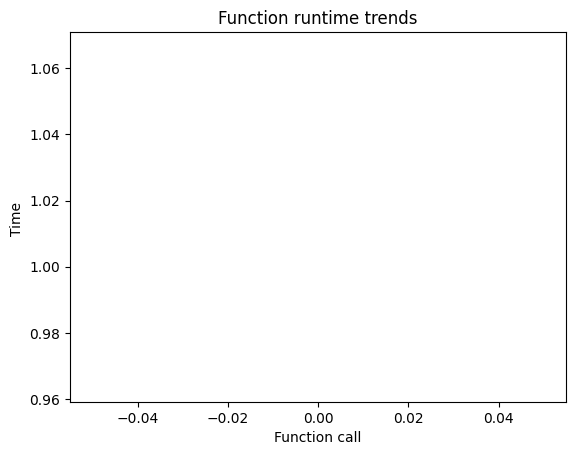

In [30]:
times=end_time - start_time
# 绘制时间趋势图
plt.plot(times)
plt.xlabel('Function call')
plt.ylabel('Time ')
plt.title('Function runtime trends')
plt.show()

In [46]:
#保存
predicted_demand_df ['sales_region_code'] = sales_region_code
predicted_demand_df.to_excel('test/result2.xlsx', index=False)


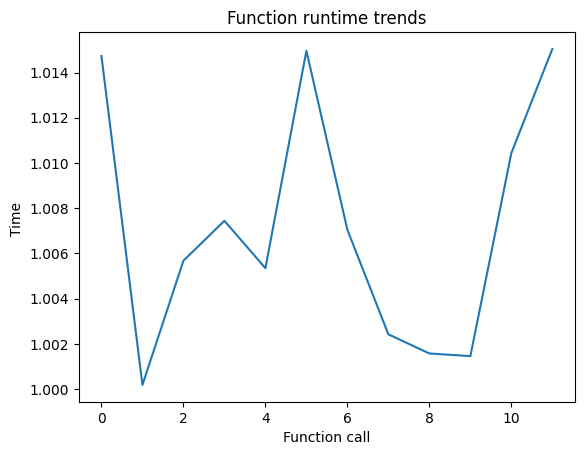

In [29]:
import time
def my_function():
    # 要执行的代码
    time.sleep(1)

# 记录函数运行时间
times = []
for i in range(12):
    start_time = time.time()
    my_function()
    end_time = time.time()
    times.append(end_time - start_time)

plt.plot(times)
plt.xlabel('Function call')
plt.ylabel('Time ')
plt.title('Function runtime trends')
plt.show()